<a href="https://colab.research.google.com/github/YaraElwakeel/Cuda_Vision_Lab-/blob/main/trial_session1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import optuna
import torch.optim as optim
from optuna.trial import TrialState

In [ ]:
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train = False,transform = transforms.ToTensor(), download = True )

In [ ]:
n_imgs_train = len(train_dataset)
n_imgs_test = len(test_dataset)

In [ ]:
print(f"# Images Train: {n_imgs_train}")
print(f"# Images Test:  {n_imgs_test}")

# Images Train: 60000
# Images Test:  10000


In [ ]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


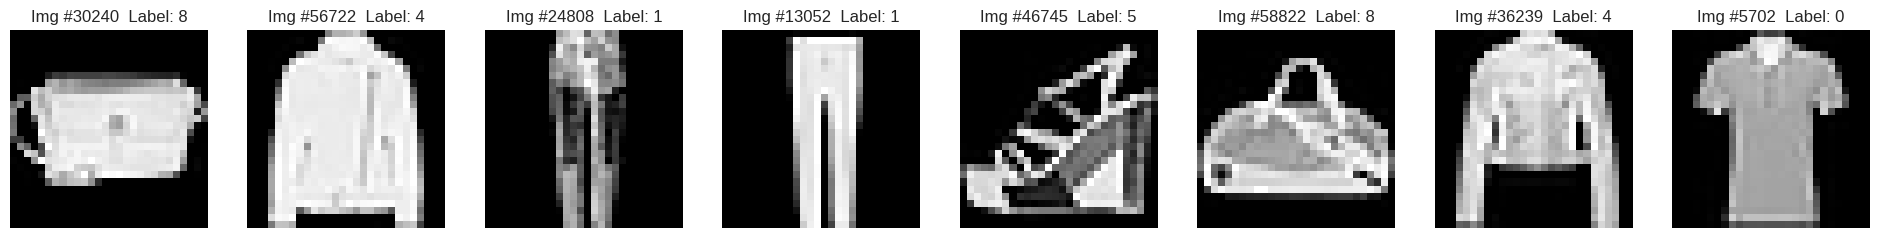

In [ ]:
import matplotlib.pyplot as plt

N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = train_dataset[n][0].numpy().reshape(28,28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    ax[i].axis("off")
plt.show()

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=[128,64], output_dim=10,droupout_prob = 0.5):
        super().__init__()
        self.layers = nn.Sequential(
                # nn.Linear(in_features=input_dim, out_features=256),
                # # nn.Dropout(droupout_prob),
                # nn.ReLU(),
                nn.Linear(in_features=input_dim, out_features=hidden_dim[0]),
                # nn.Dropout(droupout_prob),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim[0], out_features=hidden_dim[1]),
                # nn.Dropout(droupout_prob),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim[1], out_features=output_dim)
            )

    def forward(self, x):
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred

In [ ]:
NUM_EPOCHS = 20
LR = 3e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(input_dim=784, hidden_dim=[128,64], output_dim=10)
print(model)
model = model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
grad_norms = {'L1': [], 'L2': [], 'L3': []}
grad_max = {'L1': [], 'L2': [], 'L3': []}
grad_mean = {'L1': [], 'L2': [], 'L3': []}

In [ ]:
# Hook to track gradients
def save_grad_stats(layer_name, grad):
    grad_norms[layer_name].append(grad.norm().item())
    grad_max[layer_name].append(grad.max().item())
    grad_mean[layer_name].append(grad.mean().item())

# Register hooks for each layer to track gradients
model.layers[0].weight.register_hook(lambda grad: save_grad_stats('L1', grad))
model.layers[2].weight.register_hook(lambda grad: save_grad_stats('L2', grad))
model.layers[4].weight.register_hook(lambda grad: save_grad_stats('L3', grad))

In [ ]:
def get_mnist(batch_size):
  train_loader =  torch.utils.data.DataLoader(
          dataset=train_dataset,
          batch_size=batch_size,
          shuffle=True
      )

  eval_loader =  torch.utils.data.DataLoader(
          dataset=test_dataset,
          batch_size=batch_size,
          shuffle=False
      )
  return train_loader, eval_loader


In [ ]:
train_loader, eval_loader = get_mnist(batch_size=1024)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def train_per_epoch(model, train_loader, criterion, optimizer, device,epoch):
  correct = 0
  total = 0
  global loss_train_list, accuracy_train_list
  model.train()
  progress_bar = tqdm(train_loader, total=len(train_loader))

  for i, (imgs, labels) in enumerate(progress_bar):
      # using GPU
      imgs, labels = imgs.to(device), labels.to(device)
      # forward pass
      flattened_imgs = imgs.flatten(start_dim=1)
      preds = model(flattened_imgs)

      # computing error
      loss = criterion(preds, labels)
      loss_train_list.append(loss.item())

      # removing accumulated gradients
      optimizer.zero_grad()

      # backpropagating error to compute gradients
      loss.backward()

      # updating parameters
      optimizer.step()

      # Get predicted classes
      preds_class = torch.argmax(preds, dim=-1)

      # Count the number of correct predictions
      correct += (preds_class == labels).sum().item()

      # Total number of predictions
      total += labels.size(0)

      # Compute accuracy for the current batch
      accuracy = correct / total
      accuracy_train_list.append(accuracy)
      # Update the progress bar
      if(i % 10 == 0 or i == len(train_loader) - 1):
          progress_bar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}, accuracy {accuracy:.5f}")


def validate_per_epoch(model, val_loader, criterion, device):
  global loss_valid_list, accuracy_valid_list,preds_all
  model.eval()
  preds_all = []
  with torch.no_grad():
      for i, (imgs, labels) in enumerate(val_loader):
          imgs , labels = imgs.to(device), labels.to(device)
          flattened_imgs = imgs.flatten(start_dim=1)
          model.eval()
          preds = model(flattened_imgs)
          # loss calculation
          loss = criterion(preds, labels)
          loss_valid_list.append(loss.item())
          # accuracy calculation
          pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
          cur_correct = len(torch.where(pred_labels == labels)[0])
          accuracy_per_batch = cur_correct / len(labels) * 100
          accuracy_valid_list.append(accuracy_per_batch)
          preds_all.extend(pred_labels.cpu().numpy())



In [ ]:
from tqdm import tqdm

loss_train_list = []
accuracy_train_list = []

loss_valid_list = []
accuracy_valid_list = []

preds_all = []

for epoch in range(NUM_EPOCHS):
  train_per_epoch(model, train_loader, criterion, optimizer, device,epoch)
  validate_per_epoch(model, eval_loader, criterion, device)

Epoch 20 Iter 59: loss 0.37505, accuracy 0.87200: 100%|██████████| 59/59 [00:08<00:00,  6.93it/s]


In [ ]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

In [ ]:
def plot_training_progress(ax, x, smooth_x, ylabel, title, is_log_scale=False):
    ax.plot(x, c="blue", label="Training", linewidth=3, alpha=0.5)
    ax.plot(smooth_x, c="red", label="Smoothed", linewidth=3)
    ax.legend(loc="best")
    ax.set_xlabel("Iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if is_log_scale:
        ax.set_yscale("log")

<ipython-input-92-b624d0acdcda>:4: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



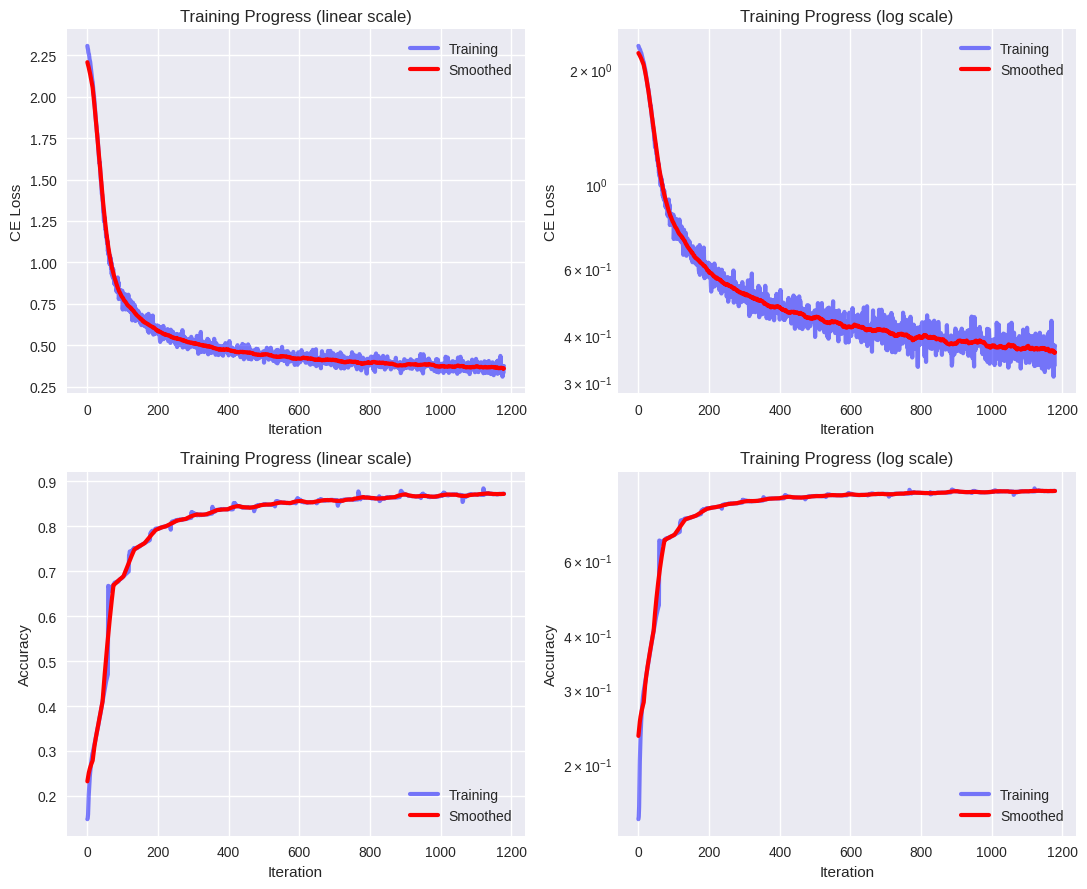

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.style.use('seaborn')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(11, 9)

# Plot Training Loss
smooth_loss = smooth(loss_train_list, 31)
plot_training_progress(ax[0][0], loss_train_list, smooth_loss, "CE Loss", "Training Progress (linear scale)")
plot_training_progress(ax[0][1], loss_train_list, smooth_loss, "CE Loss", "Training Progress (log scale)", is_log_scale=True)

# Plot Training Accuracy
smooth_accuracy = smooth(accuracy_train_list, 31)
plot_training_progress(ax[1][0], accuracy_train_list, smooth_accuracy, "Accuracy", "Training Progress (linear scale)")
plot_training_progress(ax[1][1], accuracy_train_list, smooth_accuracy, "Accuracy", "Training Progress (log scale)", is_log_scale=True)

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<ipython-input-93-935738936731>:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



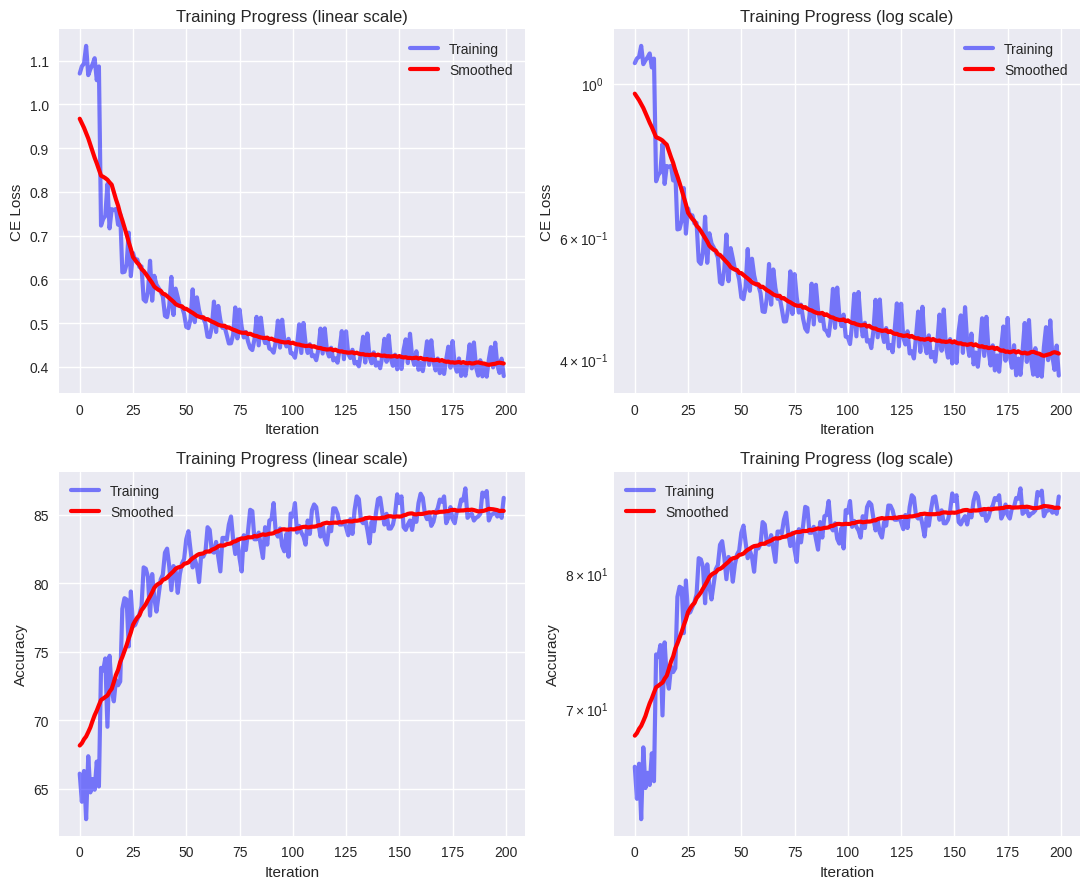

In [ ]:
# Set up the figure and axes
plt.style.use('seaborn')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(11, 9)

# Plot Training Loss
smooth_loss = smooth(loss_valid_list, 31)
plot_training_progress(ax[0][0], loss_valid_list, smooth_loss, "CE Loss", "Training Progress (linear scale)")
plot_training_progress(ax[0][1], loss_valid_list, smooth_loss, "CE Loss", "Training Progress (log scale)", is_log_scale=True)

# Plot Training Accuracy
smooth_accuracy = smooth(accuracy_valid_list, 31)
plot_training_progress(ax[1][0], accuracy_valid_list, smooth_accuracy, "Accuracy", "Training Progress (linear scale)")
plot_training_progress(ax[1][1], accuracy_valid_list, smooth_accuracy, "Accuracy", "Training Progress (log scale)", is_log_scale=True)

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Validation accuracy: 85.37%


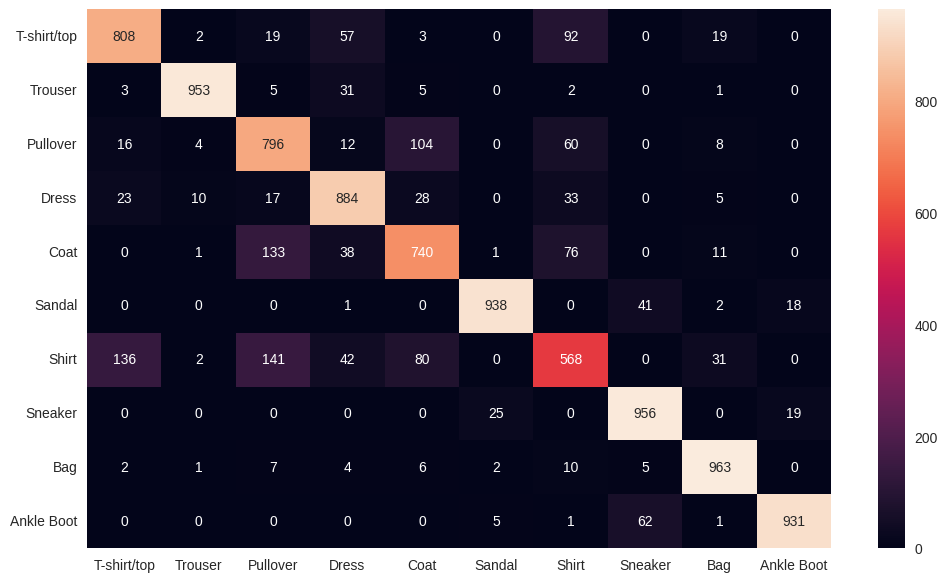

In [ ]:
from sklearn.metrics import accuracy_score
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
accuracy = accuracy_score(test_dataset.targets.cpu().numpy(), preds_all) * 100
print(f"Validation accuracy: {round(accuracy,2)}%")
cf_matrix = confusion_matrix( test_dataset.targets.cpu().numpy(), preds_all)
plt.figure(figsize = (12,7))

sn.heatmap(cf_matrix, annot=True,fmt="d",xticklabels=classes, yticklabels=classes)
plt.savefig('output.png')

the following confusion matrix shows that the model struggles the most with distinguishing between certain clothing items. Specifically in the following categories:



*   T-shirt/top misclassified as Shirt: 136 times.
*   Pullover misclassified as Coat: 133 times.
*   Shirt misclassified as T-shirt/top: 92 times

The failures are likely due to overlapping visual features among these clothing types, making it hard for the model to differentiate between them effectively as: <br>
**T-shirt/top vs. Shirt:** Both categories are visually similar in style, as they often share similar structures and materials.<br>
**Pullover vs. Coat:** Pullovers and coats might both appear bulky or have similar textures<br>
**Shirt vs. T-shirt**: Shirts and T-shirts may be confused due to similar necklines or sleeve lengths


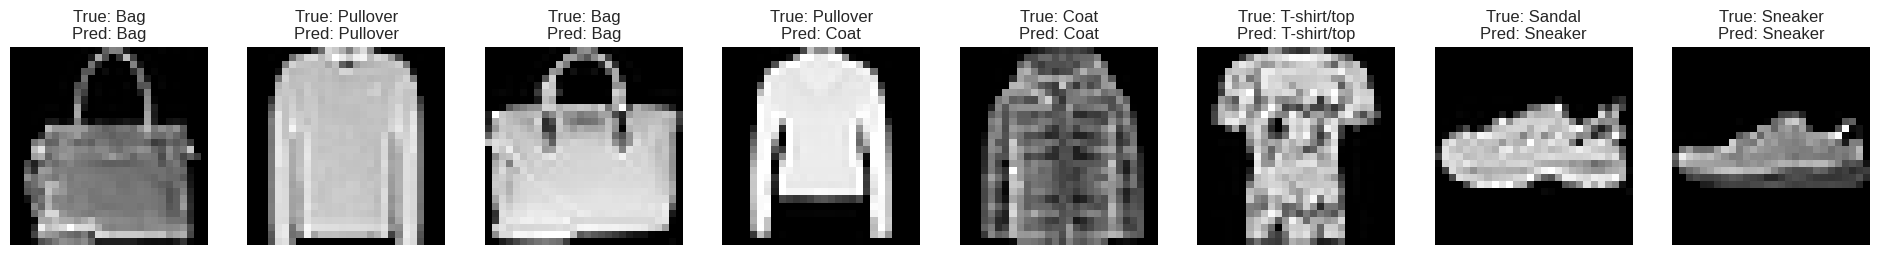

In [ ]:
# Visualize some test images with their true and predicted labels
N_IMGS = 8
fig, ax = plt.subplots(1, N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

# Randomly select N_IMGS
ids = np.random.randint(low=0, high=len(test_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    true_label = test_dataset[n][1]  # True label
    pred_label = preds_all[n]  # Predicted label
    img = test_dataset[n][0].numpy().reshape(28,28)

    # Convert the true label and predicted label to class names
    true_label_name = classes[true_label]
    pred_label_name = classes[pred_label]

    # Display the image with class names in the title
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f"True: {true_label_name}\nPred: {pred_label_name}")
    ax[i].axis("off")

plt.show()

In [ ]:
def plot_grad_stats():
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Plot norm of gradients
    axes[0].plot(grad_norms['L1'], label='L1', color='blue')
    axes[0].plot(grad_norms['L2'], label='L2', color='green')
    axes[0].plot(grad_norms['L3'], label='L3', color='red')
    axes[0].set_title('Gradient Norms')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Norm')
    axes[0].legend()

    # Plot max of gradients
    axes[1].plot(grad_max['L1'], label='L1', color='blue')
    axes[1].plot(grad_max['L2'], label='L2', color='green')
    axes[1].plot(grad_max['L3'], label='L3', color='red')
    axes[1].set_title('Gradient Max Values')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Max Value')
    axes[1].legend()

    # Plot mean of gradients
    axes[2].plot(grad_mean['L1'], label='L1', color='blue')
    axes[2].plot(grad_mean['L2'], label='L2', color='green')
    axes[2].plot(grad_mean['L3'], label='L3', color='red')
    axes[2].set_title('Gradient Mean Values')
    axes[2].set_xlabel('Iterations')
    axes[2].set_ylabel('Mean Value')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


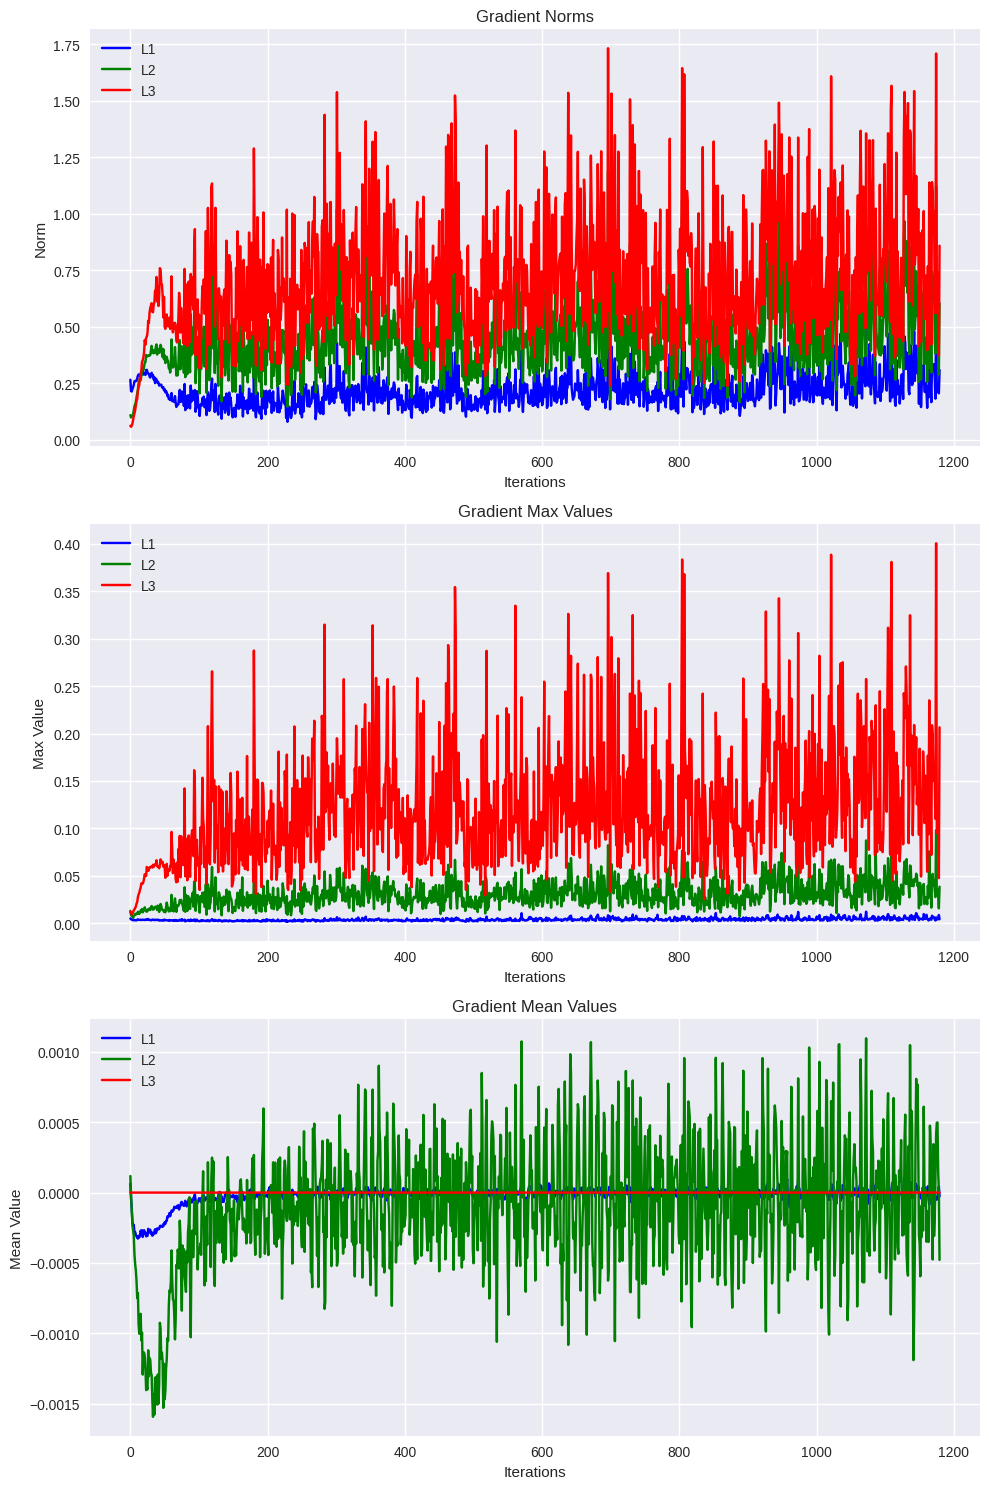

In [ ]:
plot_grad_stats()

###1. Gradient Norms:

Observation:
The gradient norms for L1 (blue) and L2 (green) remain mostly stable. While the gradient of L3 has a high variance showing some noise.

Interpretation:
L1 and L2 are relatively small and stable norms meaning that the updates for these layers are consistent and controlled.
For L3, the higher fluctuations in the gradient norms indicate that this layer experiences larger updates, which may be a sign of instability or a layer that is contributing more to the learning process.

###2. Gradient Max Values:
Observation:
The gradient max values for L1 and L2 remain low throughout training while
L3 shows significantly larger peaks in the maximum gradient values.

Interpretation:
The larger max values for L3 could indicate that individual weights in this layer are experiencing much larger updates.

###3. Gradient Mean Values:
Observation:
The gradient mean for all layers (L1, L2, L3) is close to zero. L2 (green) exhibits some minor deviation around 0 iterations but stabilizes quickly. L3 shows minimal variation as well.
Interpretation:
A mean close to zero across the layers suggests that the gradients are not biased in any particular direction.

For L1 and L2, the stable norms and low max values suggest they are contributing to training in a more controlled manner.
L3, with its larger fluctuations, may be indicative of a more sensitive or deep layer in the network that requires careful tuning, especially concerning learning rate or regularization, to prevent instability.


In [ ]:
CLASSES = 10
def define_model(trial):
    # optimize the number of layers
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    input_dim = 28 * 28
    # for each layer ,optimize its number of units, dropout
    for i in range(n_layers):
        output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(input_dim, output_dim))
        layers.append(nn.ReLU())
        dropout_prob = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(dropout_prob))

        input_dim = output_dim
    layers.append(nn.Linear(input_dim, CLASSES))

    return nn.Sequential(*layers)

In [ ]:

def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)
    criterion = nn.CrossEntropyLoss()

    #optimizers hyperparamters Suggesitions
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    # generate the optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    #Suggest batch size
    batch_size = trial.suggest_int("batch_size", 32, 256, step=32)

    N_TRAIN_EXAMPLES =  batch_size *30
    N_VALID_EXAMPLES = batch_size * 10
    # Get the FashionMNIST dataset with the suggessted batch_size
    train_loader, valid_loader = get_mnist(batch_size)

    #suggest epochs number
    num_epochs = trial.suggest_int("epochs", 5, 50)

    # Training of the model
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (data, labels) in enumerate(train_loader):
            # # Limiting validation data
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, labels = data.view(data.size(0), -1).to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(valid_loader):
                # # Limiting validation data.
                if batch_idx * batch_size >= N_VALID_EXAMPLES:
                    break
                data, labels = data.view(data.size(0), -1).to(device), labels.to(device)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-10-21 17:42:42,169] A new study created in memory with name: no-name-4b657152-5161-4b40-a85d-52158da403a6
[I 2024-10-21 17:43:14,899] Trial 0 finished with value: 0.760546875 and parameters: {'n_layers': 1, 'n_units_l0': 111, 'dropout_l0': 0.4232890497538851, 'optimizer': 'Adam', 'lr': 7.118525875957939e-05, 'batch_size': 256, 'epochs': 21}. Best is trial 0 with value: 0.760546875.
[I 2024-10-21 17:43:28,986] Trial 1 finished with value: 0.46875 and parameters: {'n_layers': 1, 'n_units_l0': 57, 'dropout_l0': 0.37031730493751924, 'optimizer': 'RMSprop', 'lr': 1.0317562028152636e-05, 'batch_size': 224, 'epochs': 11}. Best is trial 0 with value: 0.760546875.
[I 2024-10-21 17:44:13,098] Trial 2 finished with value: 0.7822916666666667 and parameters: {'n_layers': 1, 'n_units_l0': 102, 'dropout_l0': 0.248044617984172, 'optimizer': 'RMSprop', 'lr': 4.379350962878139e-05, 'batch_size': 192, 'epochs': 39}. Best is trial 2 with value: 0.7822916666666667.
[I 2024-10-21 17:44:54,519] Trial

In [ ]:
from optuna.visualization import *
# plotting optimization history
plot_optimization_history(study)

This Optimization History Plot shows the progression of the optimization process over the course of several trial, where The Objective Value is plotted against the Trial number.The objective value starts around 0.75 for the first few trials.<br>
There are some low-performing trials early on that is below 0.5, likely due to exploration of poorly performing hyperparameter combinations.
<br>
After trial 5, the objective value begins to improve, eventually reaching around 0.85 at trial 15. where The objective value remains consistently high after this point, indicating that the optimization process has found a more optimal valued for the hyperparameters .<br>
After trial 15, the optimization seems to plateau around 0.85–0.88, meaning the objective value stabilizes and further trials don't lead to significant improvements.

In [ ]:
# hyperparamters importance
plot_param_importances(study)

***n_units_10*** is the most important hyperparameter, contributing significantly to the model's performance.<br>
***optimizer*** is the second most important hyperparameter, suggesting that the choice of optimization algorithm plays a crucial role in the model's training.<br>
***lr***, ***epochs***, ***batch_size***, ***dropout_10***, and ***n_layers*** have relatively lower importances, indicating that their impact on the model's performance is less pronounced.

In [ ]:
# best trial values
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Value:  0.878515625
  Params: 
    n_layers: 2
    n_units_l0: 67
    dropout_l0: 0.2385441276455771
    n_units_l1: 90
    dropout_l1: 0.38345397528981123
    optimizer: Adam
    lr: 0.0028154766129363765
    batch_size: 256
    epochs: 48


In [ ]:
optuna.visualization.plot_slice(study)

slice plot is a visualization that helps understanding how the objective value changes as one or more hyperparameters are varied while keeping others fixed.


*   batch size :The highest objective values are observed around batch sizes of 100 and 150.
A slight drop in performance is seen for larger batch sizes between 200-250.
Reasonable range: A smaller batch size 100-150 appears optimal.
* Drop out layer 0: values around below 0.25 seem to perform better.
*   Dropout Layer 1 : values around 0.35 lead to better objective values.
The objective decreases for smaller dropout rates that are below 0.3.
*   Dropout Layer 2 :  dropouts values (0.3-0.4) give the best performance here

* Epochs: the best performance is observed at 40's epochs however it drops significantly below 20 so resonable range is belween 30 and 40
*   learning rate: between 0.002 and 0.003 seems to perform the best as there is an decrease in performance for values above 0.003
* number of layers:  the resonable range is at 2
* optimizer : Adam seems the most optimal solution






